In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas
import pointprocesses as ppr

# Données synthétiques

In [3]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [4]:
import itertools
mu = 1.0
tmax = 40.0
alpha = 0.2
beta  = 2.0

print("Expected avg evt no. %.3f" % (tmax*mu/(1.-alpha)))

Expected avg evt no. 50.000


In [5]:
n_traj = 100
sample_trajectories = [ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)) for _ in range(n_traj)]

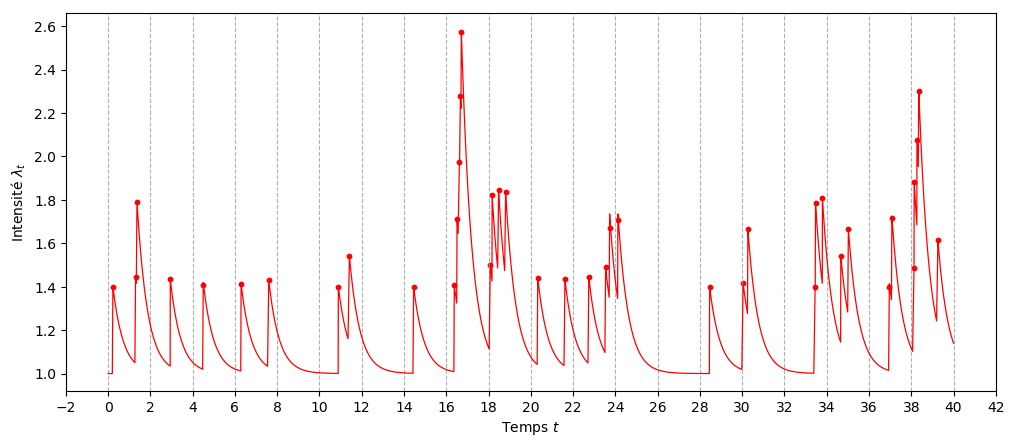

In [6]:
one_traj = sample_trajectories[0]
fig, ax = plt.subplots(1,1, figsize=(12,5), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

In [73]:
input_size = max(s.shape[0] for s in sample_trajectories)
print("Input size (max. trajectory length): %d" % input_size)
data_array = np.stack([np.pad(s[:,0], ((input_size - s.shape[0], 0),), 'constant') for s in sample_trajectories])

data_tensor = torch.from_numpy(data_array).to(torch.float32)

Input size (max. trajectory length): 71


In [74]:
data_tensor[0]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.2290,
         1.2999,  1.3678,  2.9431,  4.5026,  6.2943,  7.6007, 10.8948, 11.4176,
        14.4544, 16.3790, 16.5108, 16.6207, 16.6706, 16.7142, 18.0815, 18.1692,
        18.4765, 18.8081, 20.3293, 21.6154, 22.7437, 23.5392, 23.7293, 24.1222,
        28.4602, 30.0454, 30.2698, 33.4527, 33.4699, 33.7981, 34.6680, 35.0255,
        36.9632, 37.0843, 38.1297, 38.1368, 38.2694, 38.3571, 39.2613])

## Neural net

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as tnf

In [26]:
device = torch.device("cpu")
print(device)

cpu


In [10]:
torch.manual_seed(1)

$$
    \lambda_k(t) = f_k(\mathbf w_k^\intercal\mathbf h(t))
$$

$$
    \mathbf h(t) = \mathbf o_i \odot \tanh(\mathbf c(t))\in\mathbb R^D,\quad t\in(t_{i-1}, t_i]
$$

In [495]:
class NeuralCTLSTM(nn.Module):
    """
    A continuous-time LSTM, defined according to Eisner & Mei's article
    https://arxiv.org/abs/1612.09328
    """
    def __init__(self, hidden_dim: int):
        super(NeuralCTLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.input_g = nn.Linear(hidden_dim, hidden_dim)
        self.forget_g = nn.Linear(hidden_dim, hidden_dim)
        self.output_g = nn.Linear(hidden_dim, hidden_dim)
        
        self.ibar = nn.Linear(hidden_dim, hidden_dim)
        self.fbar = nn.Linear(hidden_dim, hidden_dim)
        
        # activation will be tanh
        self.z_gate = nn.Linear(hidden_dim, hidden_dim)
        
        # Cell decay factor
        self.decay = nn.Linear(hidden_dim, hidden_dim)
        # we can learn the parameters of this
        self.decay_act = nn.Softplus()
        
        # The hidden state contains
        # the cell state at t, the target cell state
        self.init_hidden()
        
        self.activation = nn.Softplus()
        self.weight_f = torch.rand(self.hidden_dim, device=device)
    
    def init_hidden(self, batch_size=1):
        """
        Initialize the hidden state, and the two hidden memory
        cells c and cbar.
        """
        self.hidden = (torch.rand(batch_size, self.hidden_dim, device=device),
                       torch.rand(batch_size, self.hidden_dim, device=device),
                       torch.rand(batch_size, self.hidden_dim, device=device))

    
    def c_func(self, dt: torch.Tensor, c: torch.Tensor, cbar: torch.Tensor, decay: torch.Tensor):
        """
        Compute the decayed cell memory c(t) = c(ti + dt)
        """
        #print("Computing decayed cell memory...")
        #print(c.shape, type(c))
        #print(cbar.shape, type(cbar))
        #print(decay.shape, type(decay))
        dt = dt.unsqueeze(-1)
        #print(dt, type(dt))
        return cbar + (c - cbar)*torch.exp(-decay*dt)
        
        
    def next_event(self, output, dt, decay):
        h_ti, c_ti, c_bar = self.hidden
        c_t_after = c_func(dt, c_ti, cbar, decay)
        h_t_after = output * torch.tanh(c_t_after)
        lbdaMax = h_t_after
        raise NotImplementedError
    
    def forward(self, inter_times):
        """
        inter_times: inter-arrival time for the next event in the sequence
        
        Returns:
            output : result of the output gate
            h_ti   : hidden state
            c_ti   : cell state
            cbar   : cell target
            decay_t: decay parameter on the interval
        #TODO event type embedding
        """
        # get the hidden state and memory from before
        h_ti, c_ti, cbar = self.hidden
        
        #TODO concatenate event embedding with ht
        v = torch.cat((h_ti,))
        input  = torch.sigmoid(self.input_g(v))
        forget = torch.sigmoid(self.forget_g(v))
        output = torch.sigmoid(self.output_g(v))
        
        input_bar  = torch.sigmoid(self.ibar(v))
        forget_bar = torch.sigmoid(self.fbar(v))
        
        # Not-quite-c
        zi = torch.tanh(self.z_gate(v))
        
        # Compute the decay parameter
        decay_t = self.decay_act(self.decay(v))
        
        # Now update the cell memory
        # Decay the cell memory
        c_t_after = self.c_func(inter_times, c_ti, cbar, decay_t)
        # Update the cell
        c_ti = forget * c_t_after + input * zi
        # Update the cell state asymptotic value
        cbar = forget_bar * cbar + input_bar * zi
        h_ti = output * torch.tanh(c_t_after)
        
        # Store our new states for the next pass to use
        self.hidden = h_ti, c_ti, cbar
        return output, h_ti, c_ti, cbar, decay_t

    def eval_intensity(self, dt, output, c_ti, cbar, decay):
        """
        Compute the intensity function
        t:      time to compute
        output: NN output o_i
        c_ti:   previous cell state
        cbar:   previous cell target
        decay:
        
        It is best to store the training history in variables for this.
        """
        # Get the updated c(t)
        c_t_after = self.c_func(dt, c_ti, cbar, decay)
        h_t = output * torch.tanh(c_t_after)
        try:
            pre_lambda = torch.mm(self.weight_f[None,:], h_t.t())
        except:
            print("Error occured in c_func")
            print(" dt shape %s" % str(dt.shape))
            print(" Weights shape %s" % str(self.weight_f.shape))
            print(" h_t shape %s" % str(h_t.shape))
        
            raise
        return self.activation(pre_lambda)
        
    
    def likelihood(self, inter_times, c_ti, cbar, output, decay, T):
        """
        Compute the log-likelihood
        c_ti :  entire cell state history
        output: entire output history
        decay:  entire decay history
        """
        event_times = torch.cumsum(inter_times, dim=0)
        print("event_times shape %s" % str(event_times.shape))
        # Get the intensity process
        event_intensities = [
            self.eval_intensity(inter_times[i], output[i], c_ti[i], cbar[i], decay[i])
            for i in range(event_times.size(0))
        ]
        event_intensities = torch.stack(event_intensities)
        print("event_intensities shape: %s" % str(event_intensities.shape))
        first_sum = event_intensities.log()
        print("first_sum shape: %s" % str(first_sum.shape))
        first_sum = torch.sum(first_sum, dim=0)
        print("first_sum shape: %s" % str(first_sum.shape))
        
        # The integral term is computed using a Monte Carlo method
        batch_size = output.size(1)
        # random samples in [0, T]
        samples, _ = (T*torch.rand(output.size(0)+1, batch_size)).sort(0)
        samples = samples[:-1] - samples[1:]
        print("Samples shape: %s" % str(samples.shape))
        lam_samples = torch.stack([
            self.eval_intensity(samples[i], output[i], c_ti[i], cbar[i], decay[i])
            for i in range(output.size(0))
        ])
        print("lam samples shape: %s" % str(lam_samples.shape))
        integral = torch.mean(lam_samples, dim=0)
        print("integral shape: %s" % str(integral.shape))
        # Tensor of dim. batch_size
        # of the values of the likelihood
        res = first_sum - integral
        # return the mean of that
        return res.mean().item()

In [496]:
nhlstm = NeuralCTLSTM(12)

In [497]:
output_hist = []
hidden_hist = []
cell_hist = []
cell_target_hist = []
decay_hist = []

BATCH_SIZE = 2
print("Batch size: %d" % BATCH_SIZE)
feed_data = data_tensor[:,:BATCH_SIZE]
feed_data = feed_data[:-1] - feed_data[1:] # transform into inter-arrival times
print("Feed data shape: %s" % str(feed_data.shape))
with torch.no_grad():
    nhlstm.init_hidden(BATCH_SIZE)
    for i in range(feed_data.size(0)):
        output, hidden, ct, cbar, decay_t = nhlstm(feed_data[i])
        output_hist.append(output)
        hidden_hist.append(hidden)
        cell_hist.append(ct)
        cell_target_hist.append(cbar)
        decay_hist.append(decay_t)
output_hist = torch.stack(output_hist)
hidden_hist = torch.stack(hidden_hist)
cell_hist = torch.stack(cell_hist)
cell_target_hist = torch.stack(cell_target_hist)
decay_hist = torch.stack(decay_hist)

Batch size: 2
Feed data shape: torch.Size([99, 2])


In [498]:
output_hist.shape

torch.Size([99, 2, 12])

In [499]:
nhlstm.likelihood(feed_data, cell_hist, cell_target_hist, output_hist, decay_hist, tmax)

event_times shape torch.Size([99, 2])
event_intensities shape: torch.Size([99, 1, 2])
first_sum shape: torch.Size([99, 1, 2])
first_sum shape: torch.Size([1, 2])
Samples shape: torch.Size([99, 2])
lam samples shape: torch.Size([99, 1, 2])
integral shape: torch.Size([1, 2])


-38.0604362487793